In [217]:
import torch
import torch.nn as nn
from tqdm import tqdm, trange
import numpy as np
import torch.nn.functional as F
import os
import pickle
import matplotlib.pyplot as plt

In [243]:
class MaskedLinear(nn.Linear):
    def __init__(self, in_features, out_features, bias=True):
        super().__init__(in_features,out_features, bias)    
    def set_mask(self, mask: torch.Tensor):
        self.register_buffer("mask", torch.Tensor(mask).T)

    def forward(self, X):
        # print(X.shape)
        return F.linear(X, self.weight * self.mask, self.bias)

In [244]:
# MADE (maybe finish trying w/ MOL later)

class MADE(nn.Module):
    def __init__(self,in_shape,num_logistics,num_dims, hidden_sizes = [1024, 1024, 1024]):
        super(MADE, self).__init__()
        self.in_shape = in_shape
        self.flatten_shape = np.prod(self.in_shape)
        self.hidden_sizes = hidden_sizes

        self.num_logistics = num_logistics
        self.num_dims = num_dims

        # self.pi = nn.Parameter(torch.randn(self.num_logistics), requires_grad=True)
        # self.means = nn.Parameter(torch.arange(self.num_logistics).float(), requires_grad = True)
        # self.scales = nn.Parameter(torch.zeros(self.num_logistics), requires_grad=True)

        self.masking_dict = {}
        self.layer_sizes = [self.flatten_shape * self.num_dims] + self.hidden_sizes + [self.flatten_shape * self.num_dims]
        self.net = []
        for h0, h1 in zip(self.layer_sizes, self.layer_sizes[1:]):
            print(f"Created mask with dimensions {h0}x{h1}")
            self.net.extend([
                MaskedLinear(h0,h1),
                nn.ReLU()
            ])

        self.net.pop() # remove last ReLU

        self.net = nn.Sequential(*self.net)
        self.init_masks()
    def init_masks(self):
        num_hiddens = len(self.hidden_sizes)
        ordering = np.arange(self.flatten_shape)
        self.masking_dict[-1] = ordering

        for h in range(num_hiddens):
            self.masking_dict[h] = np.random.randint(low=self.masking_dict[h-1].min(), high=self.flatten_shape-1, size=self.hidden_sizes[h])
        
        masks = [self.masking_dict[h-1][:, None] <= self.masking_dict[h][None,:] for h in range(num_hiddens)]
        masks.append(self.masking_dict[num_hiddens - 1][:,None] < self.masking_dict[-1][None, :])

        # masks[0] = np.repeat(masks[0], self.num_dims, axis = 0)
        # masks[-1] = np.repeat(masks[-1], self.num_dims, axis = 1)

        layers = [l for l in self.net.modules() if isinstance(l, MaskedLinear)]

        for l,m in zip(layers,masks):
            l.set_mask(m)
    

    def forward(self, X):
        # print(X.shape)
        return self.net(X)
    # def forward(self, X):
    #     X = X.view(X.shape[0], -1).unsqueeze(-1)
    #     X = X.repeat(1,1,self.num_logistics)
    #     # print("SHAPE AFTER FLATTEN: ",X.shape)
    #     scales = torch.exp(-self.scales)
    #     plus = torch.sigmoid(scales * (X + 0.5 - self.means))
    #     minus = torch.sigmoid(scales * (X - 0.5 - self.means))

    #     log_diff = torch.log(torch.clamp(plus - minus, min=1e-12))

    #     # Edges 
    #     # Where X == 0, replace X w/ inf

    #     # Where X == dims-1

    #     at_zero = torch.sigmoid(scales * (0.5 - self.means))
    #     at_max = 1 - torch.sigmoid(scales * (self.num_dims - 1.5 - self.means))

    #     log_at_zero = torch.log(torch.clamp(at_zero, min=1e-12))
    #     log_at_max = torch.log(torch.clamp(at_max, min=1e-12))

    #     log_dists = torch.where(X < 0.001, log_at_zero, torch.where(X > self.num_dims-1-1e-3, log_at_max, log_diff))

    #     logits = F.log_softmax(self.pi, dim=0)

    #     out = logits + log_dists
    #     # print("POW: ",out.shape)
    #     return torch.logsumexp(out, dim=2)

    def sample(self, N):
        samples = torch.zeros(N, self.flatten_shape)
        for ix in range(self.flatten_shape):
            probs = self(samples)[:, ix]
            probs = torch.sigmoid(probs)
            logits = torch.bernoulli(probs)
            samples[:, ix] = logits
        
        return samples.reshape(N, *self.in_shape)



In [247]:
mnist_data_path = "./data/mnist.pkl"

with open(mnist_data_path, "rb") as f:
    mnist_data = pickle.load(f)
train_data = mnist_data["train"]
test_data = mnist_data["test"]

In [248]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = MADE((28,28, 1),4,1,[1024,1024])
model = model.to(device)
num_epochs = 10
train_data = torch.Tensor(train_data)
train_data[train_data >=1] = 1.
test_data = torch.Tensor(test_data)
test_data[test_data >=1] = 1.
test_data = test_data.reshape(test_data.shape[0], -1)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)

optim = torch.optim.Adam(model.parameters(), lr= 0.003)
loss_fn = nn.BCEWithLogitsLoss()
losses = []
test_losses = []
for epoch in trange(num_epochs):
    for src in train_loader:
        optim.zero_grad()
        src = src.to(device)
        batch_size = src.shape[0]
        src = src.view(batch_size, -1)
        tgt = src
        tgt.to(device)

        preds = model(src)
        # print("SRC SHAPE: ", src)
        # print("PREDS: ", preds)
    #     break
    # break



        loss = loss_fn(preds, src)
        # print(loss)

        losses.append(loss.item())
        loss.backward()
        optim.step()
    with torch.no_grad():
        preds = model(test_data)
        loss = loss_fn(preds, test_data)
        test_losses.append(loss.item())

        

Created mask with dimensions 784x1024
Created mask with dimensions 1024x1024
Created mask with dimensions 1024x784


100%|██████████| 10/10 [14:55<00:00, 89.60s/it] 


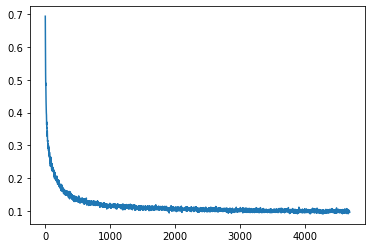

In [249]:
plt.plot(losses)

In [257]:
with torch.no_grad():
    samps = model.sample(100)

In [258]:
from torchvision.utils import make_grid
def show_samples(samples, fname=None, nrow=10, title='Samples'):
    samples = (torch.FloatTensor(samples)).permute(0, 3, 1, 2)
    grid_img = make_grid(samples, nrow=nrow)
    plt.figure()
    plt.title(title)
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.axis('off')

    if fname is not None:
        print("Yow")
    else:
        plt.show()

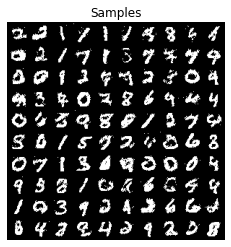

In [259]:
show_samples(samps)